In [1]:
import warnings

warnings.filterwarnings("ignore")

import pyscenic
import loompy as lp
import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import os
import glob
import json
import zlib
import base64
import anndata as ad

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [54]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.8
-----
PIL                 10.3.0
appnope             0.1.4
asttokens           NA
backcall            0.2.0
backports           NA
beta_ufunc          NA
binom_ufunc         NA
cffi                1.17.0
cloudpickle         3.1.1
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
cytoolz             0.12.2
dask                2023.5.0
dateutil            2.9.0
debugpy             1.8.12
decorator           5.1.1
executing           2.2.0
h5py                3.11.0
hypergeom_ufunc     NA
igraph              0.11.5
importlib_resources NA
invgauss_ufunc      NA
ipykernel           6.29.5
jaraco              NA
jedi                0.19.2
jinja2              3.1.5
joblib              1.4.2
kiwisolver          1.4.5
leidenalg           0.10.2
llvmlite            0.38.1
loompy              3.0.8
lz4                 4.3.3
markupsafe          2.1.5
matplotlib          3.7.5
matplotlib_inline   0.1.7
more_itertools      10.3.0
mp

# Data load and preparation

In [65]:
adata = sc.read_h5ad("3_cluster.h5ad")
adata.shape

(2561, 29620)

In [4]:
adata.var["feature_types"].unique()

['Gene Expression']
Categories (1, object): ['Gene Expression']

In [66]:
tfs_path = "../data/reference/mouse/allTFs_mm.txt"
loom_path = "../data/scenic/data_processed_input.loom"
loom_path_output = "../data/scenic/data_processed_output.loom"

In [6]:
tfs = [tf.strip() for tf in open(tfs_path)]
tfs

['1700009N14Rik',
 '1700080O16Rik',
 '1810024B03Rik',
 '2010315B03Rik',
 '2310011J03Rik',
 '2410141K09Rik',
 '2610044O15Rik8',
 '2810403A07Rik',
 '3300002I08Rik',
 '3830417A13Rik',
 '4921501E09Rik',
 '4921509C19Rik',
 '5730507C01Rik',
 '6720489N17Rik',
 '9030624G23Rik',
 '9130019O22Rik',
 '9130023H24Rik',
 'A1cf',
 'Abcf2',
 'Abl1',
 'Acaa1a',
 'Acaa1b',
 'Aco1',
 'Adarb1',
 'Adnp',
 'Adnp2',
 'Aebp2',
 'Aff4',
 'Agap2',
 'Aggf1',
 'Agmat',
 'Ahctf1',
 'Ahr',
 'Ahrr',
 'AI987944',
 'Aire',
 'Ak6',
 'Akr1a1',
 'Alx1',
 'Alx3',
 'Alx4',
 'Anxa1',
 'Anxa11',
 'Apex1',
 'Apex2',
 'Ar',
 'Arfgap1',
 'Arg1',
 'Arg2',
 'Arid3a',
 'Arid3b',
 'Arid3c',
 'Arid5a',
 'Arid5b',
 'Arnt',
 'Arnt2',
 'Arntl',
 'Arntl2',
 'Arx',
 'Asap3',
 'Ascc1',
 'Ascl1',
 'Ascl2',
 'Ash2l',
 'Aspscr1',
 'Atf1',
 'Atf2',
 'Atf3',
 'Atf4',
 'Atf5',
 'Atf6',
 'Atf6b',
 'Atf7',
 'Atoh1',
 'Atoh7',
 'Atoh8',
 'AU041133',
 'Aven',
 'AW146154',
 'AW822073',
 'B230307C23Rik',
 'Bach1',
 'Bach2',
 'Bad',
 'Banp',
 'Barhl1',

In [67]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(
    f"%{np.sum(adata.var['gene_symbol'].isin(tfs))} out of {len(tfs)} TFs are found in the object"
)

%1506 out of 1721 TFs are found in the object


In [68]:
use_hvg = True
if use_hvg:
    mask = (adata.var["highly_variable"] == True) | adata.var.index.isin(
        tfs
    )
    adata = adata[:, mask]

In [69]:
row_attributes = {
    "Gene": np.array(adata.var['gene_symbol']),
}
col_attributes = {
    "CellID": np.array(adata.obs.index),
    "nGene": np.array(np.sum(adata.X.transpose() > 0, axis=0)).flatten(),
    "nUMI": np.array(np.sum(adata.X.transpose(), axis=0)).flatten(),
}

lp.create(loom_path, adata.X.transpose(), row_attributes, col_attributes)

# SCENIC

In [70]:
num_workers = 8

In [103]:
outpath_adj = "../data/scenic/adj.csv"
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --method grnboost2 --num_workers {num_workers} --seed 42

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2025-02-21 09:07:55,278 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-02-21 09:07:56,077 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated,

In [75]:
results_adjacencies = pd.read_csv("../data/scenic/adj.csv", index_col=False, sep=",")
print(f"Number of associations: {results_adjacencies.shape[0]}")
results_adjacencies.head()

Number of associations: 551738


,TF,target,importance
0,Sod1,Rn7sk,135.823771
1,Sod1,Rpph1,120.452779
2,Sod1,ENSMUSG00000141422,111.219197
3,Sod1,Gm22973,107.134943
4,Sod1,Gm26316,101.993292


(-10.0, 10.0)

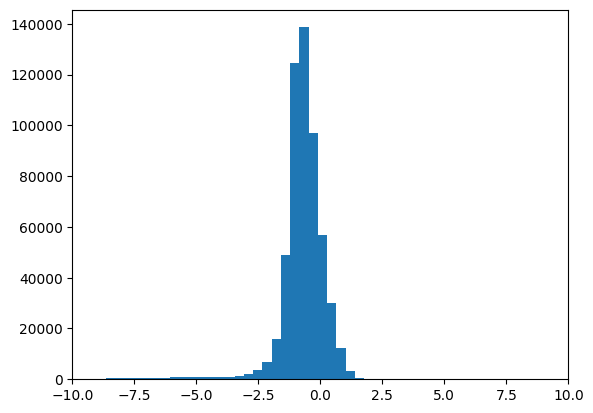

In [76]:
plt.hist(np.log10(results_adjacencies["importance"]), bins=50)
plt.xlim([-10, 10])

In [77]:
# ranking databases
db_glob = "../data/reference/mouse/*feather"
db_names = " ".join(glob.glob(db_glob))

In [78]:
# motif databases
motif_path = "../data/reference/mouse/motifs-v10nr_clust-nr.mgi-m0.001-o0.0.tbl"

In [79]:
reg_path = "../data/scenic/reg.csv"

In [87]:
if not os.path.exists(reg_path):
    !pyscenic ctx {outpath_adj} \
        {db_names} \
        --annotations_fname {motif_path} \
        --expression_mtx_fname {loom_path} \
        --output {reg_path} \
        --mask_dropouts \
        --num_workers {num_workers} > pyscenic_ctx_stdout.txt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2025-02-21 00:57:13,013 - pyscenic.cli.pyscenic - INFO - Creating modules.

2025-02-21 00:57:13,165 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-02-21 00:57:14,017 - pyscenic.utils - INFO - Calculating Pearson correlations.

2025-02-21 00:57:14,093 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2025-02-21 00:57:16,155 

In [88]:
n_genes_detected_per_cell = np.sum(adata.X > 0, axis=1)
percentiles = pd.Series(n_genes_detected_per_cell.flatten().A.flatten()).quantile(
    [0.01, 0.05, 0.10, 0.20, 0.50, 1]
)
print(percentiles)

0.01      70.0
0.05      90.0
0.10     120.0
0.20     238.0
0.50     770.0
1.00    4632.0
dtype: float64


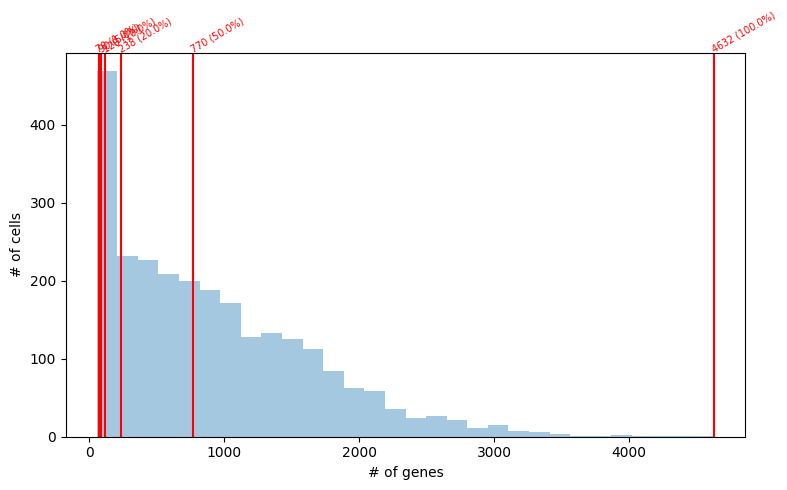

In [89]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(n_genes_detected_per_cell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

In [91]:
if not os.path.exists(loom_path_output):
    !pyscenic aucell $loom_path \
        {reg_path} \
        --output {loom_path_output} \
        --seed 42 \
        --num_workers {num_workers} > pyscenic_aucell_stdout.txt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2025-02-21 01:01:23,334 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2025-02-21 01:01:24,131 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.

2025-02-21 01:01:24,275 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use 

In [92]:
# collect SCENIC AUCell output
lf = lp.connect(loom_path_output, mode="r+", validate=False)
auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [93]:
ad_auc_mtx = ad.AnnData(auc_mtx)
sc.pp.neighbors(ad_auc_mtx, n_neighbors=10, metric="correlation")
sc.tl.umap(ad_auc_mtx)
sc.tl.tsne(ad_auc_mtx)
sc.tl.leiden(ad_auc_mtx, resolution=1)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [94]:
adata.obsm["X_umap_scenic"] = ad_auc_mtx.obsm["X_umap"]
adata.obsm["X_pca_scenic"] = ad_auc_mtx.obsm["X_pca"]
adata.obs["leiden_scenic"] = ad_auc_mtx.obs["leiden"]
adata.obsm["X_tsne_scenic"] = ad_auc_mtx.obsm["X_tsne"]

In [95]:
ad_auc_mtx

AnnData object with n_obs × n_vars = 2561 × 76
    obs: 'leiden'
    uns: 'neighbors', 'umap', 'tsne', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_tsne'
    obsp: 'distances', 'connectivities'

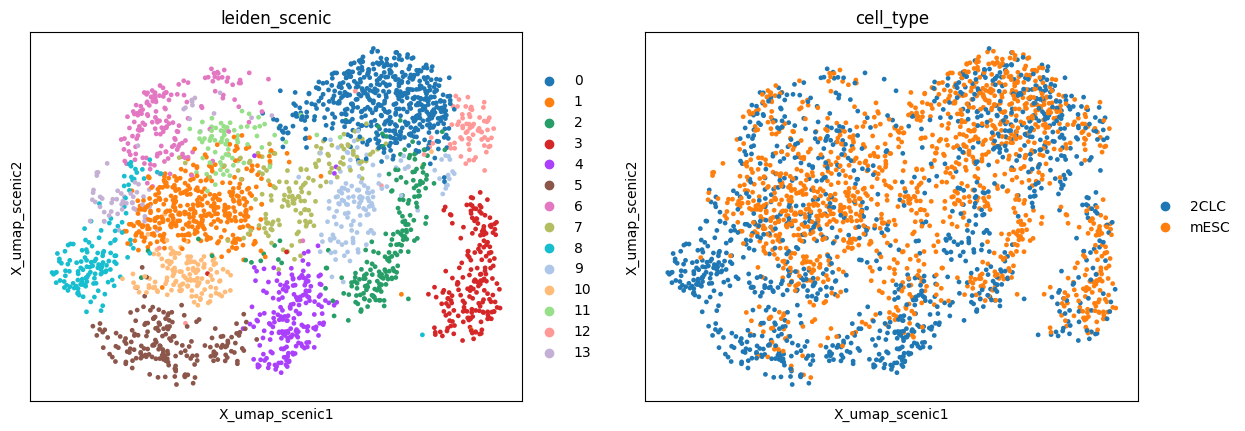

In [96]:
sc.pl.embedding(adata, basis="X_umap_scenic", color=["leiden_scenic", "cell_type"])

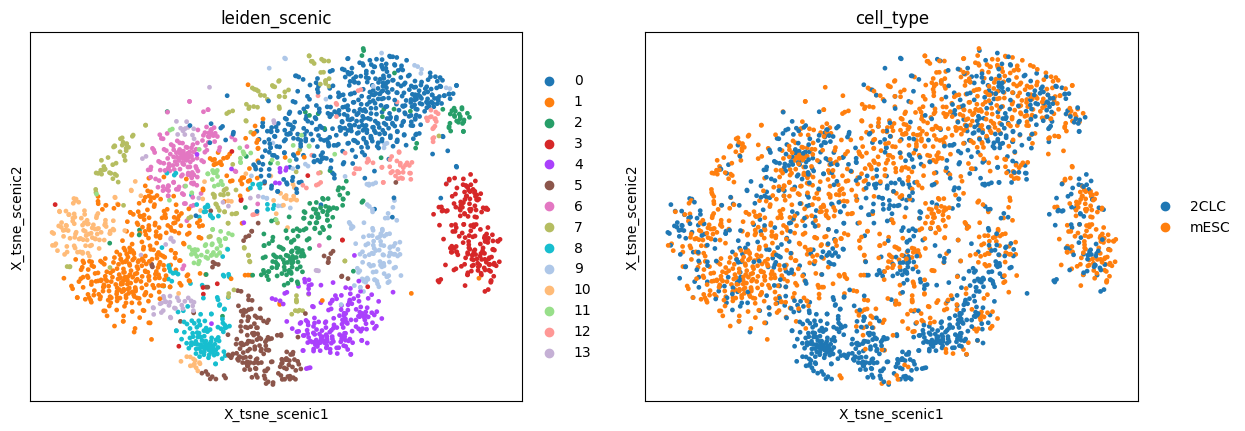

In [97]:
sc.pl.embedding(adata, basis="X_tsne_scenic", color=["leiden_scenic", "cell_type"])

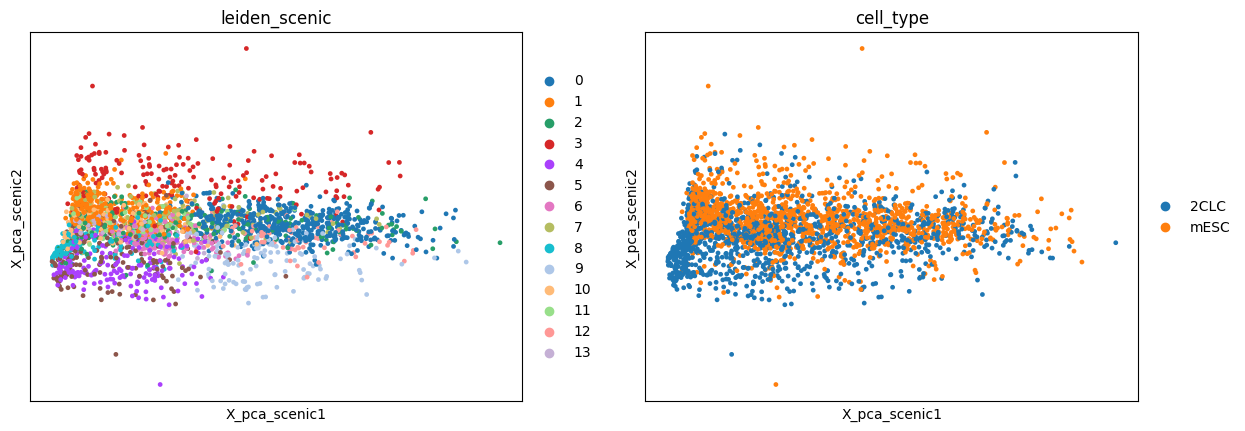

In [98]:
sc.pl.embedding(adata, basis="X_pca_scenic", color=["leiden_scenic", "cell_type"])

In [99]:
auc_mtx["cell_type"] = adata.obs["cell_type"]
mean_auc_by_cell_type = auc_mtx.groupby("cell_type").mean()

In [100]:
top_n = 50
top_tfs = mean_auc_by_cell_type.max(axis=0).sort_values(ascending=False).head(top_n)
mean_auc_by_cell_type_top_n = mean_auc_by_cell_type[
    [c for c in mean_auc_by_cell_type.columns if c in top_tfs]
]

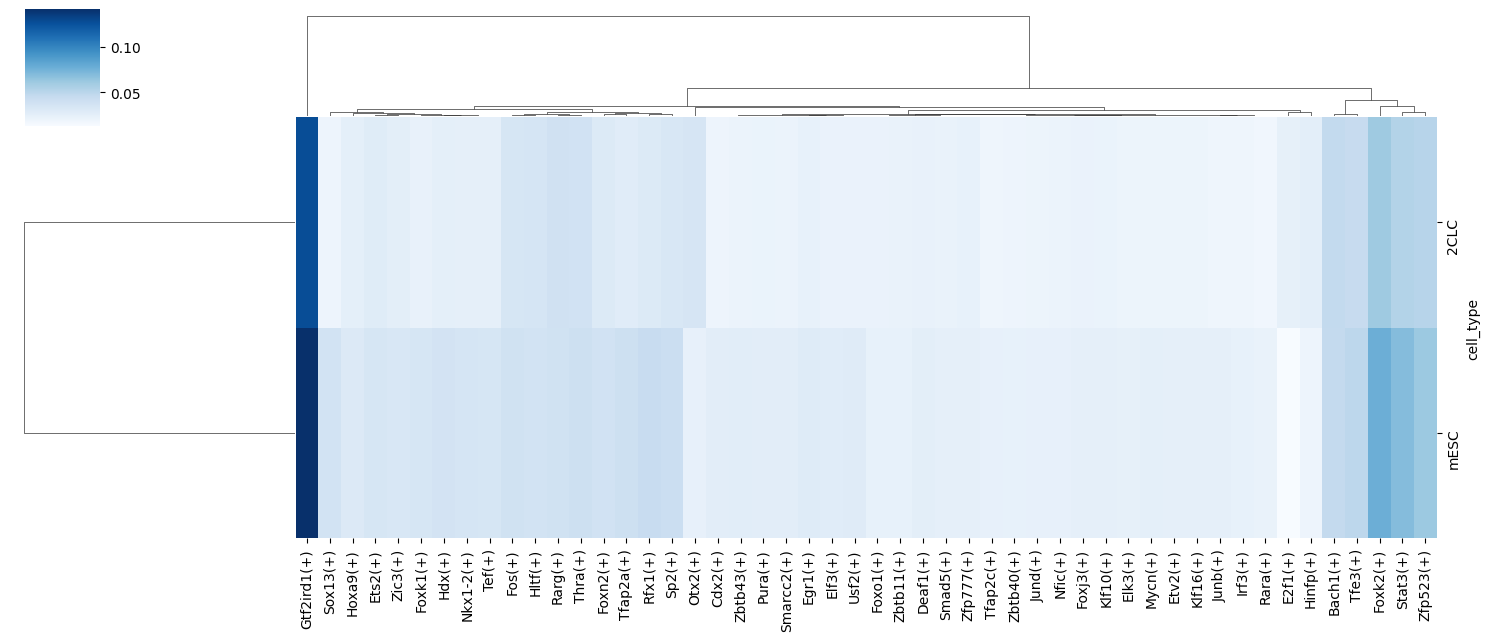

In [101]:
sns.clustermap(
    mean_auc_by_cell_type_top_n,
    figsize=[15, 6.5],
    cmap="Blues",
    xticklabels=True,
    yticklabels=True,
)